In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm_notebook
import torch.nn.functional as F
from text_vae.cvae import RnnVae
from text_vae.corpus import SSTCorpus
from text_vae.metrics import Evaluator
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_

In [3]:
path = Bunch(
    vae_save='vae.pt',
    save='text_vae.pt'
)

In [4]:
!nvidia-smi

Thu May 24 20:26:52 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 16%   55C    P8    18W / 250W |    614MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 35%   56C    P8    19W / 250W |     19MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
device_code = 3
device_s = f'cuda:{device_code}' if device_code >= 0 and torch.cuda.is_available() else 'cpu'
device = torch.device(device_s)
args, model = torch.load(path.vae_save, map_location=device_s)
model.encoder_rnn.flatten_parameters()
model.decoder_rnn.flatten_parameters()
args.device_code = device_code
assert model.x_emb.weight.device == device
device, model

(device(type='cuda', index=3), RnnVae(
   (x_emb): Embedding(5894, 50, padding_idx=0)
   (encoder_rnn): GRU(50, 64)
   (q_mu): Linear(in_features=64, out_features=64, bias=True)
   (q_logvar): Linear(in_features=64, out_features=64, bias=True)
   (decoder_rnn): GRU(116, 66)
   (decoder_fc): Linear(in_features=66, out_features=5894, bias=True)
   (conv3): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
   (conv4): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
   (conv5): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
   (disc_fc): Sequential(
     (0): Dropout(p=0.5)
     (1): Linear(in_features=300, out_features=2, bias=True)
   )
   (encoder): ModuleList(
     (0): GRU(50, 64)
     (1): Linear(in_features=64, out_features=64, bias=True)
     (2): Linear(in_features=64, out_features=64, bias=True)
   )
   (decoder): ModuleList(
     (0): GRU(116, 66)
     (1): Linear(in_features=66, out_features=5894, bias=True)
   )
   (vae): ModuleList(
     (0): Embedding(5894, 50, paddi

In [36]:
args.train.lambda_u = 0.1
args.train.lambda_z = 0.1
args.train.lambda_c = 0.1
args.train.beta = 0.1
args.train.n_iter = 10000
args

{'model': {'d_h': 64,
  'd_z': 64,
  'd_c': 2,
  'n_len': 17,
  'n_vocab': 10000,
  'd_emb': 50,
  'p_word_dropout': 0.3,
  'freeze_embeddings': False},
 'train': {'n_batch': 32,
  'lr': 0.001,
  'lr_decay': 1000,
  'n_iter': 10000,
  'lr_factor': 0.01,
  'log_interval': 3000,
  'grad_clipping': 5,
  'kl': {'i_start': 3000, 'w_start': 0.01, 'w_max': 0.4},
  'bleu_val_hypot': 200,
  'bleu_test_hypot': 200,
  'lambda_u': 0.1,
  'lambda_z': 0.1,
  'lambda_c': 0.1,
  'beta': 0.1},
 'device_code': 3}

In [37]:
corpus = SSTCorpus(**args.model, n_batch=args.train.n_batch, device=device)

In [38]:
evaluator = Evaluator(corpus)

In [39]:
class TempAnnealer:
    def __init__(self, n_iter, eps=1e-5):
        self.n_iter = n_iter
        self.eps = eps
    
    def __call__(self, i):
        kl_weight = (math.tanh((i - self.n_iter / 2) / (self.n_iter / 10)) + 1) / 2
        return 1 - kl_weight + self.eps

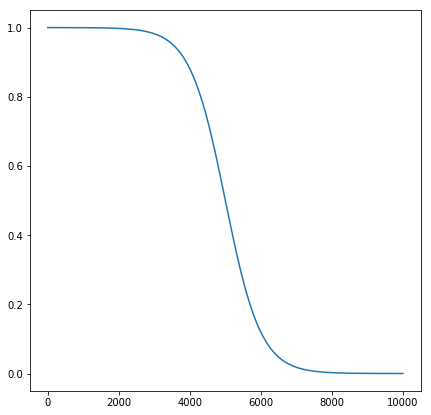

In [40]:
temp_annealer = TempAnnealer(n_iter=args.train.n_iter)
xs = np.linspace(0, args.train.n_iter, num=1000)
ts = np.array([temp_annealer(i) for i in xs])
plt.figure(figsize=(7, 7))
plt.plot(xs, ts);

In [41]:
get_params_E = lambda: (p for p in model.encoder.parameters() if p.requires_grad)
get_params_G = lambda: (p for p in model.decoder.parameters() if p.requires_grad)
get_params_D = lambda: (p for p in model.discriminator.parameters() if p.requires_grad)
trainer_E = optim.Adam(get_params_E(), lr=args.train.lr)
trainer_G = optim.Adam(get_params_G(), lr=args.train.lr)
trainer_D = optim.Adam(get_params_D(), lr=args.train.lr)

In [45]:
model.train()
batcher = corpus.batcher('labeled', 'train', n_iter=args.train.n_iter)
t = tqdm_notebook(enumerate(batcher))
losses, log, epoch = [], [], 0
for i, (x, y) in t:
    # >Train the discriminator D by Eq.(11)
    cw = model.forward_discriminator(x)
    _, c_gen, x_gen = model.sample_sentence(x.size(0))
    cw_gen = model.forward_discriminator(x_gen)
    loss_s = F.cross_entropy(cw, y)
    entropy_gen = -(F.log_softmax(cw_gen, dim=1)).mean()
    loss_u = F.cross_entropy(cw_gen, c_gen.argmax(1)) + args.train.beta * entropy_gen
    loss_D = loss_s + args.train.lambda_u * loss_u
    
    trainer_D.zero_grad()
    loss_D.backward()
    clip_grad_norm_(get_params_D(), args.train.grad_clipping)
    trainer_D.step()

    # >Train the generator G and the encoder E by Eq.(8)
    kl_loss, recon_loss = model(x, use_c_prior=False)
    z_gen, c_gen, x_gen = model.sample_soft_embed(x.size(0), temp=temp_annealer(i))
    z_gen_pred, _ = model.forward_encoder(x_gen, do_emb=False)
    cw_gen_pred = model.forward_discriminator(x_gen, do_emb=False)
    loss_vae = args.train.kl.w_max * kl_loss + recon_loss
    loss_z = F.mse_loss(z_gen_pred, z_gen)
    loss_c = F.cross_entropy(cw_gen_pred, c_gen.argmax(1))
    loss_G = loss_vae + args.train.lambda_z * loss_z + args.train.lambda_c + loss_c
    
    trainer_G.zero_grad()
    loss_G.backward()
    clip_grad_norm_(get_params_G(), args.train.grad_clipping)
    trainer_G.step()
    
    # >and minimizing Eq.(4), respectively.
    kl_loss, recon_loss = model(x, use_c_prior=False)
    loss_E = args.train.kl.w_max * kl_loss + recon_loss
    
    trainer_E.zero_grad()
    loss_E.backward()
    clip_grad_norm_(get_params_E(), args.train.grad_clipping)
    trainer_E.step()
    
    # Calc metrics and update t
    
    losses.append(loss_D.item() + loss_G.item() + loss_E.item())
    cur_loss = np.mean(losses[-args.train.log_interval:])
#     lr_D, lr_G, lr_E = (trainer.param_groups[0]['lr'] for trainer in (trainer_D, trainer_G, trainer_E))
    t.set_postfix_str(f'loss={cur_loss:.5f} loss_D={loss_D.item():.5f} loss_G={loss_G.item():.5f} loss_E={loss_E.item():.5f}')
    t.refresh()

KeyboardInterrupt: 